### Soil water balance module
Based on: Global land-surface evaporation estimated from satellite-based
observations

In [589]:
from data_processing import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from infiltration_models import *
import os

#segoe ui font
plt.rcParams['font.sans-serif'] = "Segoe UI"


#### Equations
Potential Evaporation

$\lambda E_{p} = \alpha * \frac{\Delta}{\Delta + \gamma} * (R_{n} - G) $

Actual Evapotranspiration

$E = S*E_{p} + I - \beta*I$ 

Evaporative stress  
Tall canopy:  

$S = 1 -(\frac{\omega_{c} - \omega_{w}}{\omega_{c} - \omega_{wp}}) ^ 2$

Short vegetation:  

$S = 0.5 * (1 - \sqrt(\frac{\omega_{c} - \omega_{w}}{\omega_{c} - \omega_{wp}}) + \frac{\tau}{0.8})$

Bare Soil:  

$S = 1 - \sqrt(\frac{\omega_{c} - \omega_{w}}{\omega_{c} - \omega_{wp}})$



### Parameters

In [ ]:
alpha_tall_canopy = 0.8
alpha_short_canopy = 1.26 #short veg. and bare soil
frac_tall_canopy = 0.5
frac_short_canopy = 0.3
frac_bare_soil = 0.2
beta = 0.07
s_fc = 0.321
s_sat = 0.482
s_wp = 0.137

LAI = 3.5
tau = 0.8 #or 0.2 a parameter accounting for the development of vegetation over the year (vegetation optical depth).
Ks=12.19 #Saturated hydraulic conductivity in mm/h (Silt Loam) -->>> from SPAW model
S=34.3 #Sorptivity in mm/h^0.5

### Input data

In [591]:
#calculate PET from  data in data_processing.py
#source directory
src=r"W:\VUB\_main_research\scripts\wetland_model\conceptual_model\data"

pET_k = 0.408 * (delta/(delta + gamma)) * net_radiation
precip=pd.read_csv(os.path.join(src,"Boechout_precip_ETo.csv"), index_col=0)
precip.index=pd.to_datetime(precip.index, format='%d/%m/%Y')

#surface soil moisture data extracted from SMAP
smap_ssm=pd.read_excel(src+"/smap_surface_sm_boechout_9km.xlsx", index_col=0)
smap_ssm.index=pd.to_datetime(smap_ssm.index) 

### Initialize variable arrays

In [ ]:
# Number of time steps
n_steps = len(precip)

# Pre-allocate arrays with zeros
interception = np.zeros(n_steps)  # Interception array
infil = np.zeros(n_steps)         # Infiltration array
perco = np.zeros(n_steps)         # Percolation array
sm = np.zeros(n_steps) 
E_stress_tc = np.zeros(n_steps) # Evaporation stress tall canopy
E_stress_sc = np.zeros(n_steps) # Evaporation stress short canopy
E_stress_bs = np.zeros(n_steps) # Evaporation stress
evap_actual_tc = np.zeros(n_steps)
evap_actual_sc = np.zeros(n_steps)
evap_actual_bs = np.zeros(n_steps)
total_evap = np.zeros(n_steps)
AWC = np.zeros(n_steps)


# Initial conditions
sm[0] = s_fc  # Initial soil moisture is at field capacity
E_stress_tc[0] = 1  # Initial evaporation stress is 1
E_stress_sc[0] = 1  
E_stress_bs[0] = 1  
infil[0] = 0.5 * s_fc  # max infiltration at the start
perco[0] = 0  # No percolation at the start
total_evap[0] = 0
evap_actual_tc[0] =  0.5
evap_actual_sc[0] =  0.5
evap_actual_bs[0] =  0.5
interception[0] = 0.1  #
AWC[0] = 0.5
soil_depth = 300  # mm

### Soil moisture simulation

In [593]:
dt = 1  # Time step in days

# Loop through time steps
for time in range(1, n_steps - 1):
    # Step 1: Calculate interception
    interception[time] = min(precip['precipitation'].iloc[time], 0.05 * LAI)

    # Step 2: Evaporate interception first
    if interception[time] >= pET_k.iloc[time]:
        # If interception alone satisfies PET, total ET is limited to PET
        total_evap[time] = pET_k.iloc[time]
        evap_actual_tc[time] = 0  # No evaporation from tall canopy
        evap_actual_sc[time] = 0  # No evaporation from short canopy
        evap_actual_bs[time] = 0  # No evaporation from bare soil
    else:
        # Subtract interception from PET to calculate remaining PET
        remaining_PET = pET_k.iloc[time] - interception[time]

        # Step 3: Calculate evaporation stress for different components
        E_stress_tc[time] = max(0,1 - ((s_fc - sm[time - 1]) / (s_fc - s_wp))**2)
        E_stress_sc[time] = max(0,0.5 * (1 - np.sqrt((s_fc - sm[time-1]) / (s_fc - s_wp)) + tau / 0.8))
        E_stress_bs[time] = max(0,1 - np.sqrt((s_fc - sm[time-1]) / (s_fc - s_wp)))

        # Calculate potential evaporation for each component
        pot_evap_tc = remaining_PET * frac_tall_canopy * alpha_tall_canopy
        pot_evap_sc = remaining_PET * frac_short_canopy * alpha_short_canopy
        pot_evap_bs = remaining_PET * frac_bare_soil * alpha_short_canopy

        # Calculate actual evaporation for each component
        evap_actual_tc[time] = pot_evap_tc * E_stress_tc[time]
        evap_actual_sc[time] = pot_evap_sc * E_stress_sc[time]
        evap_actual_bs[time] = pot_evap_bs * E_stress_bs[time]

        # Step 4: Calculate total ET
        total_evap[time] = (
            interception[time] + evap_actual_tc[time] + evap_actual_sc[time] + evap_actual_bs[time]
        )

    # Step 5: Calculate infiltration
    #caculate available water capacity
    AWC[time] = s_fc - sm[time-1]

    #Calculate cumulative infiltration using the explicit infiltration models for sandy loam soil: 
    # Create an instance of the model
    infiltration_model = InfiltrationModel(Ks, S)

    # Calculate cumulative daily infiltration in mm
    daily_infiltration = infiltration_model.valiantzas_model(dt) * 24  # converting hourly to daily
    infil[time] = min(daily_infiltration, precip['precipitation'].iloc[time] - interception[time])

    # Step 6: Update soil moisture (before percolation)
    sm[time] = sm[time - 1] + (infil[time] - total_evap[time]) / soil_depth

    # Step 7: Calculate percolation if soil moisture exceeds field capacity
    if sm[time] >= s_fc:
        perco[time] = (sm[time] - s_fc) * soil_depth  # Excess water becomes percolation
        sm[time] = s_fc  # Soil moisture is capped at field capacity
    else:
        perco[time] = 0  # No percolation if below field capacity

    # Step 8: Enforce lower boundary for soil moisture
    sm[time] = max(s_wp, sm[time])  # Prevent negative soil moisture


#### Transform arrays to dataframes

In [594]:
#convert arrays to pandas series
model_arrays = [interception, infil, perco, sm, evap_actual_tc, evap_actual_sc, evap_actual_bs, total_evap]
array_names = ['Interception', 'Infiltration', 'Percolation', 'Soil Moisture', 'Evap tall canopy', 'Evap short canopy', 'Evap bare soil', 'Total Evapotranspiration']
model_df = pd.DataFrame(model_arrays, index=array_names).T
model_df.index = pET_k.index

Text(0, 0.5, 'Soil Moisture (mm/mm)')

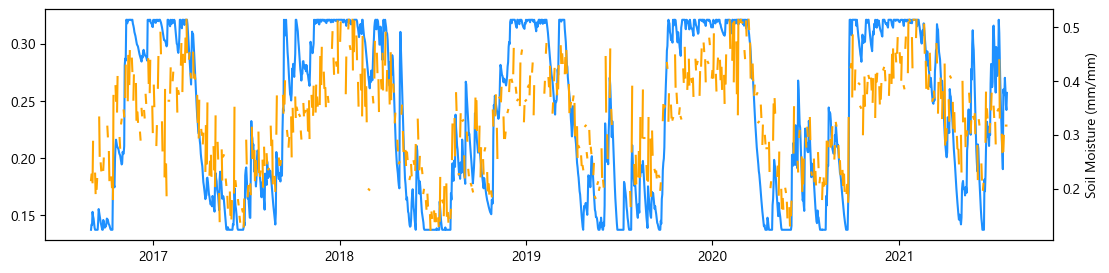

In [595]:
start_date='2016-09-01'
end_date='2021-07-31'

fig,ax=plt.subplots(figsize=(13,3))
ax1 = ax.twinx()
#plt.plot(500*perco[200:4800])
#plt.plot(E_stress_bs)[200:-1]
ax.plot(model_df['Soil Moisture'][start_date:end_date], color='dodgerblue')
ax1.plot(smap_ssm['soil_moisture_am'][start_date:end_date], c='orange')
plt.ylabel('Soil Moisture (mm/mm)')

In [596]:
#monthly percolation
monthly_perco = model_df['Percolation'].resample('ME').sum()
(monthly_perco*300).groupby(monthly_perco.index.year).sum().mean()

89759.55565905858

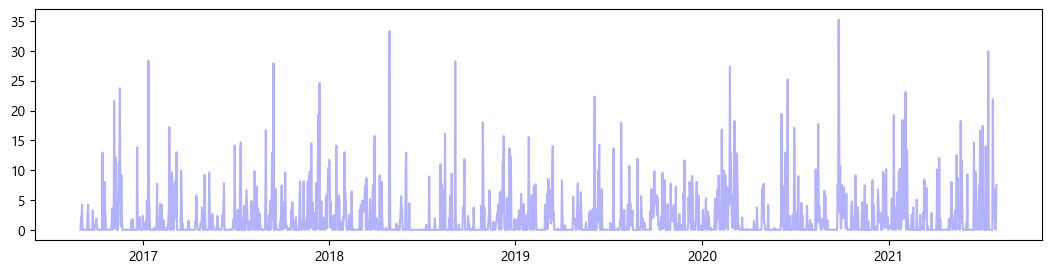

In [597]:
fig,ax=plt.subplots(figsize=(13,3))
# plt.plot(model_df['Evap tall canopy'][start_date:end_date], c='m')
# plt.plot(model_df['Evap short canopy'][start_date:end_date], c='limegreen')
# plt.plot(model_df['Evap bare soil'][start_date:end_date], c = 'orange')
# plt.plot(model_df['Total Evapotranspiration'][start_date:end_date])
# plt.plot(pET_k[start_date:end_date], c =  'black', alpha=0.3)
# plt.ylabel('Evapotranspiration (mm/day)')
plt.plot(model_df['Infiltration'][start_date:end_date], c='blue', alpha=0.3)
#plt.plot(model_df['Percolation'][start_date:end_date], c='red', alpha=0.3)

In [598]:
#compute water balance
#output fluxes
annual_fluxes = model_df.resample('YE').sum().mean()

#input fluxes
precip_annual = precip['precipitation'].resample('YE').sum().mean()

wb = precip_annual - annual_fluxes['Percolation'] - annual_fluxes['Total Evapotranspiration']

#excess water
excess_water = precip['precipitation'] - model_df['Percolation'] - model_df['Total Evapotranspiration']

In [599]:
print('Annual Water balance:')
print('-----------------------------')

print('Precipitation:', np.round(precip_annual,2))
print('Total Evapotranspiration:', np.round(annual_fluxes['Total Evapotranspiration'].sum(),2))
print('Percolation:', np.round(annual_fluxes['Percolation'].sum(),2))
print('Water balance:', np.round(wb,2))

Annual Water balance:
-----------------------------
Precipitation: 827.96
Total Evapotranspiration: 512.08
Percolation: 299.2
Water balance: 16.68


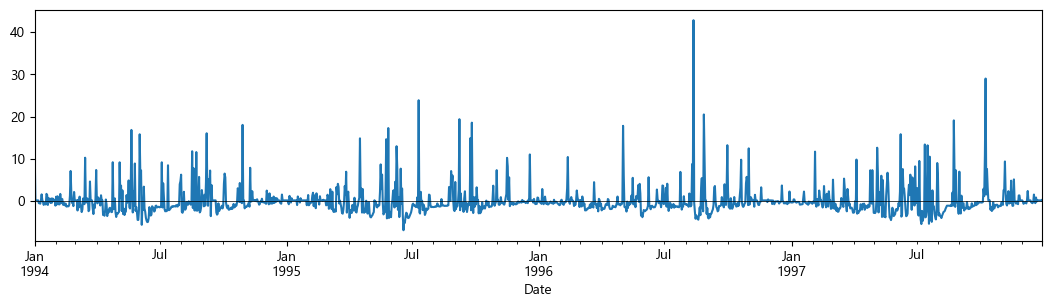

In [600]:
excess_water[0:1460].plot(figsize=(13,3))
plt.axhline(0, color='black', lw=0.5)